In [1]:

!wget https://github.com/todn0320/breast_Ultrasound_image/raw/main/Dataset_BUSI_with_GT.z01
!wget https://github.com/todn0320/breast_Ultrasound_image/raw/main/Dataset_BUSI_with_GT.zip

!zip -F /content/Dataset_BUSI_with_GT.zip --out /content/Dataset_BUSI_with_GT_total.zip
!unzip Dataset_BUSI_with_GT_total.zip

--2024-06-11 11:10:51--  https://github.com/todn0320/breast_Ultrasound_image/raw/main/Dataset_BUSI_with_GT.z01
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/todn0320/breast_Ultrasound_image/main/Dataset_BUSI_with_GT.z01 [following]
--2024-06-11 11:10:52--  https://raw.githubusercontent.com/todn0320/breast_Ultrasound_image/main/Dataset_BUSI_with_GT.z01
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104857600 (100M) [application/octet-stream]
Saving to: ‘Dataset_BUSI_with_GT.z01’

Dataset_BUSI_with_G 100%[===================>] 100.00M   225MB/s    in 0.4s    

2024-06-11 11:10:55 (225 MB/s) - ‘

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [11]:
!pip install timm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [7]:
image_size = (224, 224)  # Swin Transformer 모델의 입력 크기

# Define a transform to convert images to RGB
convert_to_rgb = transforms.Lambda(lambda image: image.convert('RGB'))

train_transform=transforms.Compose([
    convert_to_rgb,
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform=transforms.Compose([
    convert_to_rgb,
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
EPOCHS = 100
#batch size can also be a learnable hyperparameter, but it was not included in the grid search
BATCH_SIZE = 16

In [9]:
# Function to exclude mask files
def is_not_mask(filename):
    return not filename.endswith('_mask.png')

# 데이터셋 로드 및 전처리
ds = ImageFolder('/content/Dataset_BUSI_with_GT', transform=train_transform, is_valid_file=is_not_mask)

print(ds.classes)
print(len(ds))
image, label = ds[0]
print(image.shape)

print("Number of samples: ", len(ds))
print("Detected Classes are: ", ds.class_to_idx)

train_size = int(0.7 * len(ds)) # 70% for training
val_size = int(0.15 * len(ds)) # 15% for validation
test_size = len(ds) - train_size - val_size # 15% for testing

train_ds, val_ds, test_ds = random_split(ds, [train_size, val_size, test_size])
print(f"train: {len(train_ds)} test: {len(test_ds)} val: {len(val_ds)}")
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


['benign', 'malignant', 'normal']
798
torch.Size([3, 224, 224])
Number of samples:  798
Detected Classes are:  {'benign': 0, 'malignant': 1, 'normal': 2}
train: 558 test: 121 val: 119


In [14]:
# 모델 초기화 (Swin Transformer 사용)
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=3)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct / total
    return val_loss, val_acc

num_epochs = 50
best_val_loss = float('inf')

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

test_predicted_classes = []
test_true_classes = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_loss += criterion(outputs, labels).item()

        test_predicted_classes.extend(predicted.cpu().numpy())
        test_true_classes.extend(labels.cpu().numpy())

test_accuracy = test_correct / test_total
test_loss /= len(test_loader)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Epoch [1/50], Train Loss: 1.0880, Val Loss: 1.0168, Val Acc: 0.5630
Epoch [2/50], Train Loss: 1.0207, Val Loss: 0.9875, Val Acc: 0.5630
Epoch [3/50], Train Loss: 1.0031, Val Loss: 0.9867, Val Acc: 0.5210
Epoch [4/50], Train Loss: 1.0098, Val Loss: 1.0101, Val Acc: 0.5630
Epoch [5/50], Train Loss: 1.0027, Val Loss: 0.9721, Val Acc: 0.5630
Epoch [6/50], Train Loss: 0.9962, Val Loss: 0.9802, Val Acc: 0.5630
Epoch [7/50], Train Loss: 1.0020, Val Loss: 0.9933, Val Acc: 0.5630
Epoch [8/50], Train Loss: 0.9942, Val Loss: 1.0029, Val Acc: 0.5630
Epoch [9/50], Train Loss: 1.0035, Val Loss: 0.9773, Val Acc: 0.5630
Epoch [10/50], Train Loss: 0.9888, Val Loss: 0.9935, Val Acc: 0.5630
Epoch [11/50], Train Loss: 0.9914, Val Loss: 0.9725, Val Acc: 0.5630
Epoch [12/50], Train Loss: 0.9939, Val Loss: 0.9721, Val Acc: 0.5630
Epoch [13/50], Train Loss: 0.9940, Val Loss: 0.9769, Val Acc: 0.5630
Epoch [14/50], Train Loss: 0.9912, Val Loss: 0.9739, Val Acc: 0.5630
Epoch [15/50], Train Loss: 1.0034, Val Loss

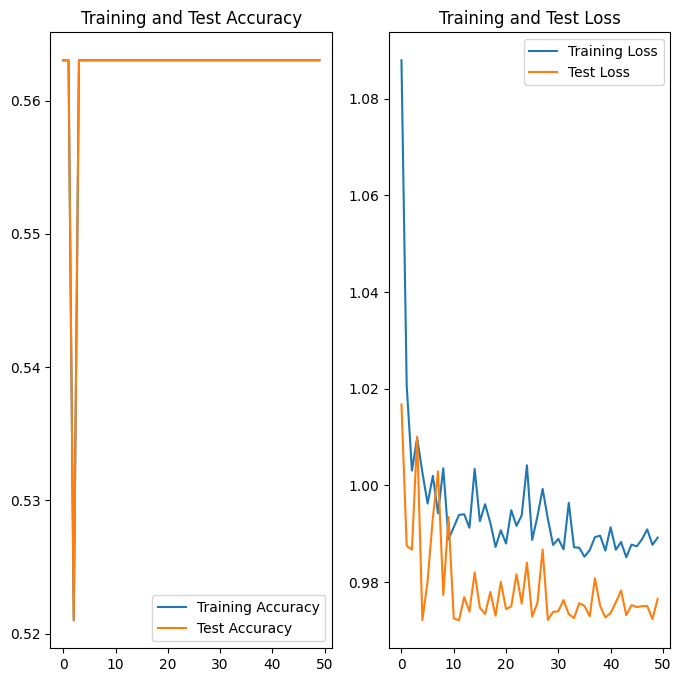

In [15]:
# 훈련 및 검증 손실 및 정확도 시각화
acc = val_accuracies
test_acc = val_accuracies

loss = train_losses
test_loss = val_losses

epochs_range = range(num_epochs)
test_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(test_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, torch.tensor(loss).cpu(), label='Training Loss')
plt.plot(test_range, torch.tensor(test_loss).cpu(), label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.show()

step: 0
predict: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') accuracy: 50.0 loss: [1.0879720017901457, 1.0206671786564652, 1.0030632181406876, 1.0097563651300245, 1.0026841088862402, 0.9962260547931904, 1.0019587398002652, 0.9942116429728847, 1.0035316677076416, 0.9888350232954948, 0.9913621551247054, 0.9938787409908882, 0.9940230449040731, 0.9912177236703988, 1.003403753362676, 0.9925883952862046, 0.9961034768798446, 0.9922339463319403, 0.98725631929213, 0.9907094129097505, 0.9879610929437863, 0.9948614944693863, 0.9916183132424576, 0.9937969527364204, 1.0041563899713606, 0.9887239886013838, 0.9935492764237106, 0.9992718965776505, 0.993062495971666, 0.9876668500216631, 0.9889308844415945, 0.986747121298185, 0.9963887556052122, 0.9871867839580796, 0.9870959941204304, 0.9852478305498759, 0.9865822924507989, 0.9892922682574146, 0.9895907080728948, 0.9864877904615095, 0.9913353411527518, 0.986665523607671, 0.9882827424661234, 0.9851239829935053, 0.98774568068

step: 1
predict: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') accuracy: 50.0 loss: [1.0879720017901457, 1.0206671786564652, 1.0030632181406876, 1.0097563651300245, 1.0026841088862402, 0.9962260547931904, 1.0019587398002652, 0.9942116429728847, 1.0035316677076416, 0.9888350232954948, 0.9913621551247054, 0.9938787409908882, 0.9940230449040731, 0.9912177236703988, 1.003403753362676, 0.9925883952862046, 0.9961034768798446, 0.9922339463319403, 0.98725631929213, 0.9907094129097505, 0.9879610929437863, 0.9948614944693863, 0.9916183132424576, 0.9937969527364204, 1.0041563899713606, 0.9887239886013838, 0.9935492764237106, 0.9992718965776505, 0.993062495971666, 0.9876668500216631, 0.9889308844415945, 0.986747121298185, 0.9963887556052122, 0.9871867839580796, 0.9870959941204304, 0.9852478305498759, 0.9865822924507989, 0.9892922682574146, 0.9895907080728948, 0.9864877904615095, 0.9913353411527518, 0.986665523607671, 0.9882827424661234, 0.9851239829935053, 0.98774568068

step: 2
predict: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') accuracy: 62.5 loss: [1.0879720017901457, 1.0206671786564652, 1.0030632181406876, 1.0097563651300245, 1.0026841088862402, 0.9962260547931904, 1.0019587398002652, 0.9942116429728847, 1.0035316677076416, 0.9888350232954948, 0.9913621551247054, 0.9938787409908882, 0.9940230449040731, 0.9912177236703988, 1.003403753362676, 0.9925883952862046, 0.9961034768798446, 0.9922339463319403, 0.98725631929213, 0.9907094129097505, 0.9879610929437863, 0.9948614944693863, 0.9916183132424576, 0.9937969527364204, 1.0041563899713606, 0.9887239886013838, 0.9935492764237106, 0.9992718965776505, 0.993062495971666, 0.9876668500216631, 0.9889308844415945, 0.986747121298185, 0.9963887556052122, 0.9871867839580796, 0.9870959941204304, 0.9852478305498759, 0.9865822924507989, 0.9892922682574146, 0.9895907080728948, 0.9864877904615095, 0.9913353411527518, 0.986665523607671, 0.9882827424661234, 0.9851239829935053, 0.98774568068

step: 3
predict: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') accuracy: 25.0 loss: [1.0879720017901457, 1.0206671786564652, 1.0030632181406876, 1.0097563651300245, 1.0026841088862402, 0.9962260547931904, 1.0019587398002652, 0.9942116429728847, 1.0035316677076416, 0.9888350232954948, 0.9913621551247054, 0.9938787409908882, 0.9940230449040731, 0.9912177236703988, 1.003403753362676, 0.9925883952862046, 0.9961034768798446, 0.9922339463319403, 0.98725631929213, 0.9907094129097505, 0.9879610929437863, 0.9948614944693863, 0.9916183132424576, 0.9937969527364204, 1.0041563899713606, 0.9887239886013838, 0.9935492764237106, 0.9992718965776505, 0.993062495971666, 0.9876668500216631, 0.9889308844415945, 0.986747121298185, 0.9963887556052122, 0.9871867839580796, 0.9870959941204304, 0.9852478305498759, 0.9865822924507989, 0.9892922682574146, 0.9895907080728948, 0.9864877904615095, 0.9913353411527518, 0.986665523607671, 0.9882827424661234, 0.9851239829935053, 0.98774568068

step: 4
predict: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') accuracy: 62.5 loss: [1.0879720017901457, 1.0206671786564652, 1.0030632181406876, 1.0097563651300245, 1.0026841088862402, 0.9962260547931904, 1.0019587398002652, 0.9942116429728847, 1.0035316677076416, 0.9888350232954948, 0.9913621551247054, 0.9938787409908882, 0.9940230449040731, 0.9912177236703988, 1.003403753362676, 0.9925883952862046, 0.9961034768798446, 0.9922339463319403, 0.98725631929213, 0.9907094129097505, 0.9879610929437863, 0.9948614944693863, 0.9916183132424576, 0.9937969527364204, 1.0041563899713606, 0.9887239886013838, 0.9935492764237106, 0.9992718965776505, 0.993062495971666, 0.9876668500216631, 0.9889308844415945, 0.986747121298185, 0.9963887556052122, 0.9871867839580796, 0.9870959941204304, 0.9852478305498759, 0.9865822924507989, 0.9892922682574146, 0.9895907080728948, 0.9864877904615095, 0.9913353411527518, 0.986665523607671, 0.9882827424661234, 0.9851239829935053, 0.98774568068

step: 6
predict: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') accuracy: 62.5 loss: [1.0879720017901457, 1.0206671786564652, 1.0030632181406876, 1.0097563651300245, 1.0026841088862402, 0.9962260547931904, 1.0019587398002652, 0.9942116429728847, 1.0035316677076416, 0.9888350232954948, 0.9913621551247054, 0.9938787409908882, 0.9940230449040731, 0.9912177236703988, 1.003403753362676, 0.9925883952862046, 0.9961034768798446, 0.9922339463319403, 0.98725631929213, 0.9907094129097505, 0.9879610929437863, 0.9948614944693863, 0.9916183132424576, 0.9937969527364204, 1.0041563899713606, 0.9887239886013838, 0.9935492764237106, 0.9992718965776505, 0.993062495971666, 0.9876668500216631, 0.9889308844415945, 0.986747121298185, 0.9963887556052122, 0.9871867839580796, 0.9870959941204304, 0.9852478305498759, 0.9865822924507989, 0.9892922682574146, 0.9895907080728948, 0.9864877904615095, 0.9913353411527518, 0.986665523607671, 0.9882827424661234, 0.9851239829935053, 0.98774568068

IndexError: index 7 is out of bounds for dimension 0 with size 7

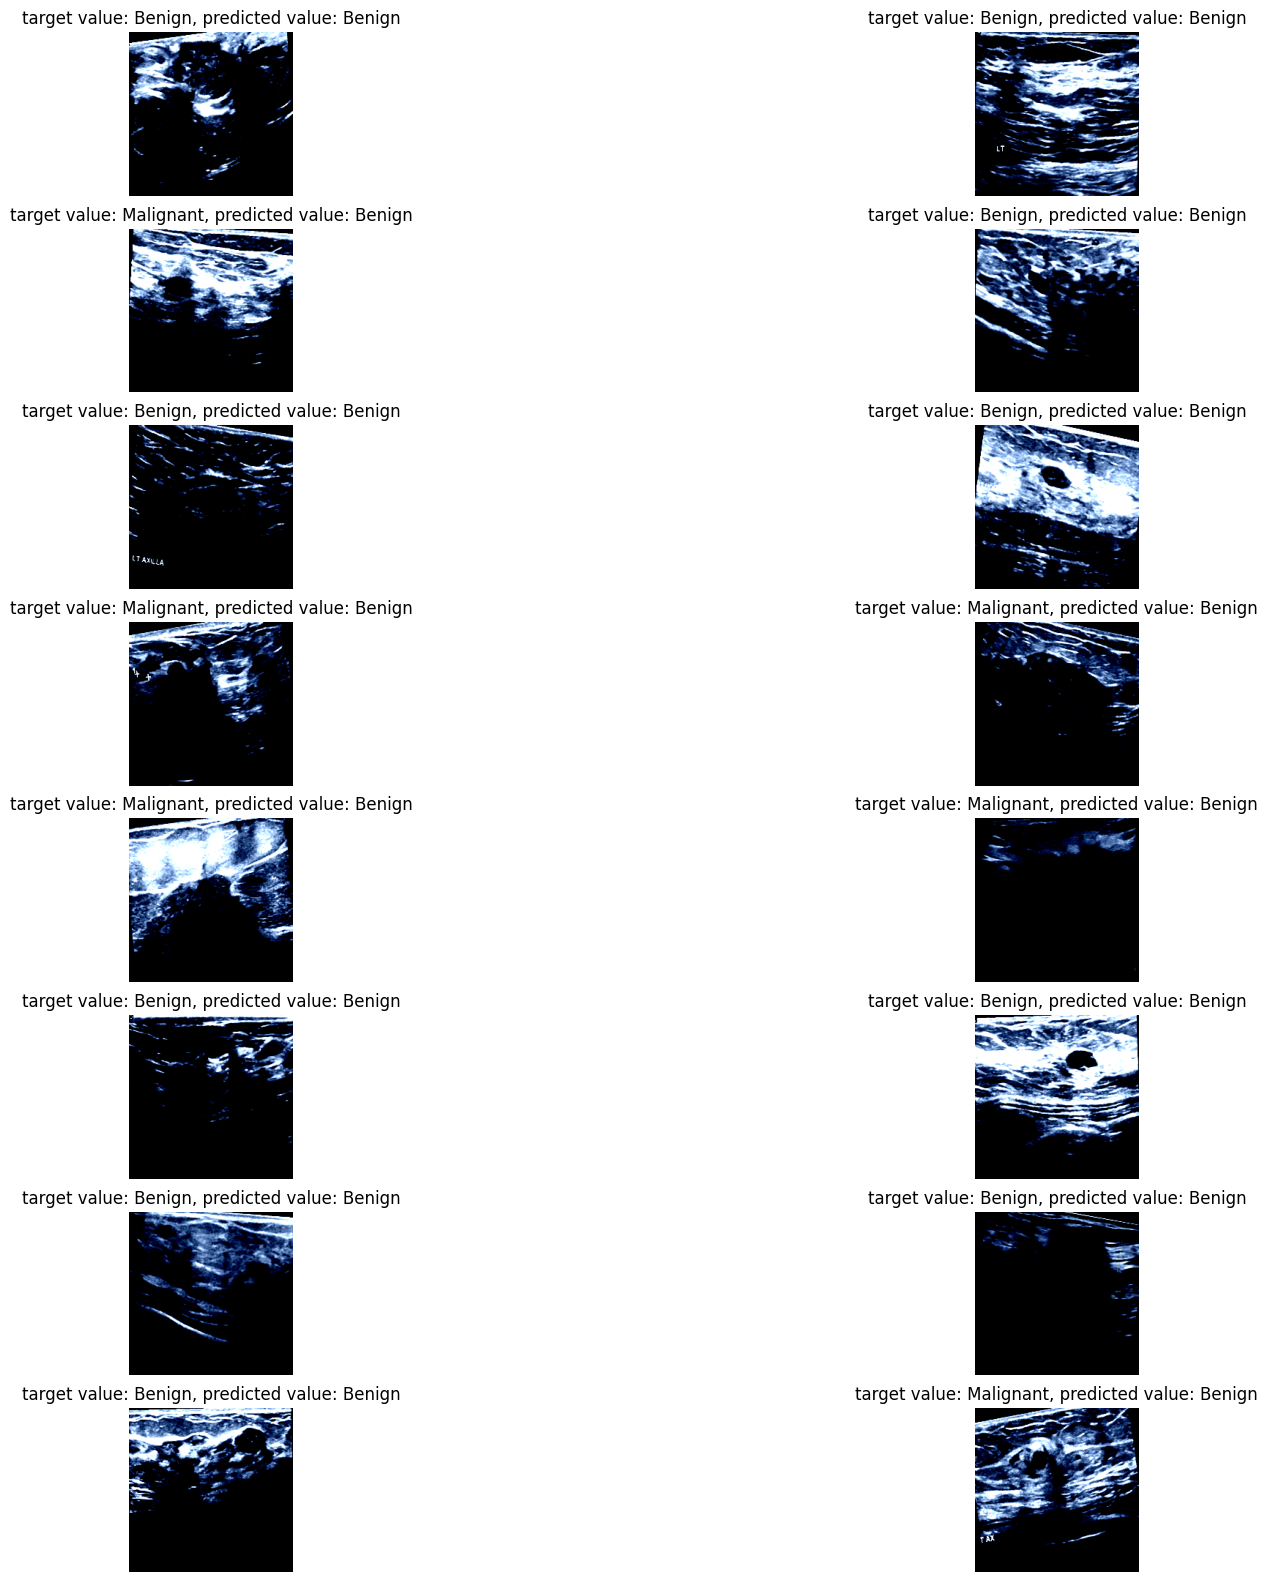

In [16]:
EVAL_BATCH = 16
eval_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

plt.figure(figsize=(20, 20))

# Disable grad
with torch.no_grad():
    for step, (x, y) in enumerate(eval_loader):
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        _, eval_predictions = torch.max(outputs, 1)
        acc_value = (eval_predictions == y)
        accuracy = acc_value.sum().item() / len(acc_value) * 100
        print(f"step: {step}")
        print(f"predict: {eval_predictions} accuracy: {accuracy} loss: {loss}")
        print(f"targets: {y}")

        for i in range(EVAL_BATCH):
            value_predicted = "Benign" if eval_predictions[i].item() == 0 else "Malignant" if eval_predictions[i].item() == 1 else "Normal"
            value_target = "Benign" if y[i].item() == 0 else "Malignant" if y[i].item() == 1 else "Normal"

            image = x[i].cpu()
            ax = plt.subplot(int(EVAL_BATCH/2), int(EVAL_BATCH/8), i + 1)
            plt.imshow(image.permute(1, 2, 0))
            plt.title(f"target value: {value_target}, predicted value: {value_predicted}")
            ax.set_axis_off()

[[75  0  0]
 [31  0  0]
 [15  0  0]]


Text(0.5, 47.7222222222222, 'Predicted Labels')

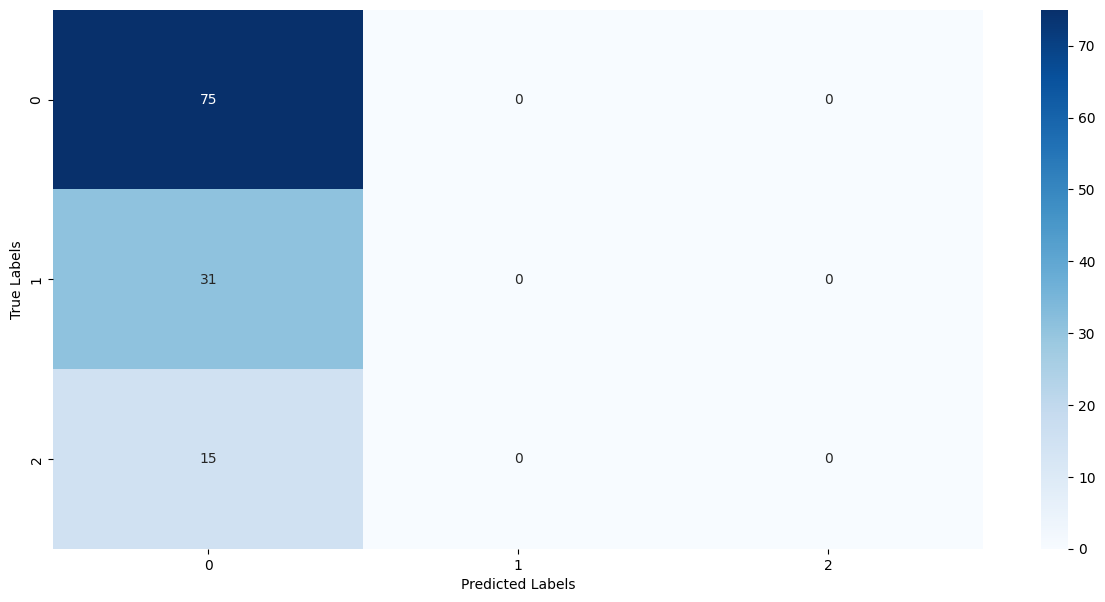

In [17]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(test_true_classes, test_predicted_classes)
print(conf_mat)
plt.figure(figsize=(15,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')